## 1. Import

In [1]:
# file/path utilities
import os
import glob
from pathlib import Path

# for data manipulation/math
import pandas as pd
import numpy as np
import random

# encoding / split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold

# progress bar
from tqdm import tqdm

# LightGBM
import lightgbm as lgb

# for feature importance visualization
import matplotlib.pyplot as plt

## 2. 하이퍼파라미터 세팅

In [2]:
#--- hyperparameter ---

SEED = 42

# cross-validation
N_SPLITS = 5  # number of folds
FOLD = 0      # which fold for validation

# LightGBM parameters
LGBM_PARAMS = {
    "objective": "regression",
    "metric": "mae",
    "boosting_type": "gbdt",
    "learning_rate": 0.05,
    "num_leaves": 63,
    "max_depth": -1,
    "min_child_samples": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "n_estimators": 2000,
    "early_stopping_rounds": 100,
    "verbose": -1,
    "random_state": SEED,
    "n_jobs": -1
}

# aggregation window (last K events)
AGG_LAST_K = 5

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)

seed_everything(SEED)

print("SEED:", SEED, "| FOLD:", FOLD)

SEED: 42 | FOLD: 0


## 3. 데이터 로드 및 전처리 (Episode → Tabular Row)

In [3]:
TRAIN_PATH = "../data/train.csv"

df = pd.read_csv(TRAIN_PATH)

# sort events inside each episode by time, then action_id
df = df.sort_values(["game_episode", "time_seconds", "action_id"]).reset_index(drop=True)

# fill missing category text
df["type_name"] = df["type_name"].fillna("__NA_TYPE__")
df["result_name"] = df["result_name"].fillna("__NA_RES__")

# encode categories
le_type = LabelEncoder()
le_res  = LabelEncoder()
df["type_id"] = le_type.fit_transform(df["type_name"])
df["res_id"]  = le_res.fit_transform(df["result_name"])

# stadium constants
STADIUM_X, STADIUM_Y = 105.0, 68.0
CENTER_Y = STADIUM_Y / 2.0
HALF_X   = STADIUM_X / 2.0
GOAL_X, GOAL_Y = STADIUM_X, CENTER_Y
GOAL_POST_HALF = 3.66
GOAL_Y_L = CENTER_Y - GOAL_POST_HALF
GOAL_Y_R = CENTER_Y + GOAL_POST_HALF
P_BOX_X_MIN = STADIUM_X - 16.5
P_BOX_Y_MIN = CENTER_Y - 20.16
P_BOX_Y_MAX = CENTER_Y + 20.16

EPS = 1e-3
SPEED_CLIP = 50.0

print("df shape:", df.shape)
print("unique episodes:", df["game_episode"].nunique())

df shape: (356721, 17)
unique episodes: 15435


In [4]:
def compute_event_features(g):
    """
    Compute per-event features for an episode DataFrame.
    Returns arrays of length T (number of events).
    """
    T = len(g)
    
    # time
    t = g["time_seconds"].astype("float32").values
    dt = np.zeros(T, dtype="float32")
    dt[1:] = t[1:] - t[:-1]
    dt[dt < 0] = 0.0
    
    # coordinates
    sx = g["start_x"].astype("float32").values
    sy = g["start_y"].astype("float32").values
    ex = g["end_x"].astype("float32").values
    ey = g["end_y"].astype("float32").values
    
    # distance to goal
    dxg = GOAL_X - sx
    dy_goal = np.maximum(0.0, np.maximum(GOAL_Y_L - sy, sy - GOAL_Y_R))
    dist_to_goal = np.sqrt(dxg**2 + dy_goal**2)
    
    # goal view angle
    alpha_L = np.arctan2(GOAL_Y_L - sy, dxg)
    alpha_R = np.arctan2(GOAL_Y_R - sy, dxg)
    theta_view = np.abs(alpha_R - alpha_L)
    
    # half line
    d_half = np.abs(sx - HALF_X)
    in_own_half = (sx < HALF_X).astype("float32")
    
    # penalty box
    in_p_box = ((sx >= P_BOX_X_MIN) & (sy >= P_BOX_Y_MIN) & (sy <= P_BOX_Y_MAX)).astype("float32")
    dx_box = np.maximum(0.0, P_BOX_X_MIN - sx)
    dy_box = np.maximum(0.0, np.maximum(P_BOX_Y_MIN - sy, sy - P_BOX_Y_MAX))
    dist_p_box = np.sqrt(dx_box**2 + dy_box**2)
    
    # event movement (dx, dy, dist)
    event_dx = ex - sx
    event_dy = ey - sy
    event_dist = np.sqrt(event_dx**2 + event_dy**2)
    
    # event speed
    event_speed = np.zeros(T, dtype="float32")
    event_speed[1:] = event_dist[:-1] / np.maximum(dt[1:], EPS)
    event_speed = np.clip(event_speed, 0.0, SPEED_CLIP)
    
    # categories
    type_id = g["type_id"].values
    res_id  = g["res_id"].values
    
    return {
        "dt": dt,
        "sx": sx, "sy": sy, "ex": ex, "ey": ey,
        "dist_to_goal": dist_to_goal,
        "theta_view": theta_view,
        "d_half": d_half,
        "in_own_half": in_own_half,
        "in_p_box": in_p_box,
        "dist_p_box": dist_p_box,
        "event_dx": event_dx,
        "event_dy": event_dy,
        "event_dist": event_dist,
        "event_speed": event_speed,
        "type_id": type_id,
        "res_id": res_id
    }

In [5]:
def episode_to_tabular(g, feats, agg_k=5):
    """
    Convert episode event features to a single tabular row.
    Uses aggregation (last event, last K mean/std/min/max, full sequence stats).
    
    IMPORTANT: For leak prevention, we exclude last event's end_x/end_y from features.
    """
    T = len(g)
    row = {}
    
    # --- Last event features (마지막 이벤트, but mask end_x/end_y) ---
    row["last_sx"] = feats["sx"][-1]
    row["last_sy"] = feats["sy"][-1]
    # ex, ey of last event is TARGET -> DO NOT USE
    row["last_dt"] = feats["dt"][-1]
    row["last_dist_to_goal"] = feats["dist_to_goal"][-1]
    row["last_theta_view"] = feats["theta_view"][-1]
    row["last_d_half"] = feats["d_half"][-1]
    row["last_in_own_half"] = feats["in_own_half"][-1]
    row["last_in_p_box"] = feats["in_p_box"][-1]
    row["last_dist_p_box"] = feats["dist_p_box"][-1]
    row["last_type_id"] = feats["type_id"][-1]
    row["last_res_id"] = feats["res_id"][-1]
    
    # --- Second-to-last event (직전 이벤트, if exists) ---
    if T >= 2:
        row["prev_sx"] = feats["sx"][-2]
        row["prev_sy"] = feats["sy"][-2]
        row["prev_ex"] = feats["ex"][-2]  # safe: not the target
        row["prev_ey"] = feats["ey"][-2]
        row["prev_dt"] = feats["dt"][-2]
        row["prev_dist_to_goal"] = feats["dist_to_goal"][-2]
        row["prev_event_dx"] = feats["event_dx"][-2]
        row["prev_event_dy"] = feats["event_dy"][-2]
        row["prev_event_dist"] = feats["event_dist"][-2]
        row["prev_event_speed"] = feats["event_speed"][-2]
        row["prev_type_id"] = feats["type_id"][-2]
        row["prev_res_id"] = feats["res_id"][-2]
    else:
        for col in ["prev_sx", "prev_sy", "prev_ex", "prev_ey", "prev_dt", 
                    "prev_dist_to_goal", "prev_event_dx", "prev_event_dy",
                    "prev_event_dist", "prev_event_speed", "prev_type_id", "prev_res_id"]:
            row[col] = 0.0
    
    # --- Last K aggregation (마지막 K개, excluding last event's end) ---
    # For continuous features, compute mean/std/min/max of last K events
    # Note: event_dist/speed of last event uses (ex[-1]-sx[-1]) which is TARGET -> exclude
    # So we use [-(agg_k+1):-1] range for safety (last K events before the final one)
    
    safe_k = min(agg_k, T - 1) if T > 1 else 0
    
    agg_cols = ["dt", "dist_to_goal", "theta_view", "d_half", "dist_p_box", 
               "event_dist", "event_speed"]
    
    for col in agg_cols:
        if safe_k > 0:
            vals = feats[col][-(safe_k+1):-1]  # exclude last event
            row[f"lastK_{col}_mean"] = np.mean(vals)
            row[f"lastK_{col}_std"] = np.std(vals) if len(vals) > 1 else 0.0
            row[f"lastK_{col}_min"] = np.min(vals)
            row[f"lastK_{col}_max"] = np.max(vals)
        else:
            row[f"lastK_{col}_mean"] = 0.0
            row[f"lastK_{col}_std"] = 0.0
            row[f"lastK_{col}_min"] = 0.0
            row[f"lastK_{col}_max"] = 0.0
    
    # --- Full sequence stats (전체 에피소드 통계, excluding last end) ---
    row["seq_len"] = T
    row["total_time"] = feats["dt"].sum()
    
    # total distance traveled (sum of event_dist, excluding last)
    if T > 1:
        row["total_dist"] = feats["event_dist"][:-1].sum()
        row["avg_speed"] = row["total_dist"] / max(row["total_time"], EPS)
    else:
        row["total_dist"] = 0.0
        row["avg_speed"] = 0.0
    
    # forward progress (x direction)
    row["forward_progress"] = feats["sx"][-1] - feats["sx"][0]
    row["lateral_range"] = feats["sy"].max() - feats["sy"].min()
    
    # start position (episode 시작점)
    row["start_sx"] = feats["sx"][0]
    row["start_sy"] = feats["sy"][0]
    
    # type/result distribution (Pass, Carry 등 비율)
    type_counts = np.bincount(feats["type_id"], minlength=len(le_type.classes_))
    for i, name in enumerate(le_type.classes_):
        row[f"type_ratio_{name}"] = type_counts[i] / T
    
    res_counts = np.bincount(feats["res_id"], minlength=len(le_res.classes_))
    for i, name in enumerate(le_res.classes_):
        row[f"res_ratio_{name}"] = res_counts[i] / T
    
    # zone ratios
    row["own_half_ratio"] = feats["in_own_half"].mean()
    row["p_box_ratio"] = feats["in_p_box"].mean()
    
    return row

In [6]:
# Build tabular dataset from all episodes
rows = []
targets_x = []
targets_y = []
episode_keys = []
episode_game_ids = []

for key, g in tqdm(df.groupby("game_episode")):
    g = g.reset_index(drop=True)
    if len(g) < 2:
        continue
    
    # target is last Pass event's end point
    if g.iloc[-1]["type_name"] != "Pass":
        pass_idxs = g.index[g["type_name"] == "Pass"]
        if len(pass_idxs) == 0:
            continue
        g = g.loc[:pass_idxs[-1]].reset_index(drop=True)
        if len(g) < 2:
            continue
    
    tx, ty = float(g.iloc[-1]["end_x"]), float(g.iloc[-1]["end_y"])
    if np.isnan(tx) or np.isnan(ty):
        continue
    
    # compute event features
    feats = compute_event_features(g)
    
    # convert to tabular row
    row = episode_to_tabular(g, feats, agg_k=AGG_LAST_K)
    
    rows.append(row)
    targets_x.append(tx)
    targets_y.append(ty)
    episode_keys.append(key)
    episode_game_ids.append(int(key.split("_")[0]))

# Create DataFrame
X = pd.DataFrame(rows)
y_x = np.array(targets_x, dtype="float32")
y_y = np.array(targets_y, dtype="float32")
episode_game_ids = np.array(episode_game_ids, dtype=np.int64)

print("X shape:", X.shape)
print("y_x shape:", y_x.shape, "| y_y shape:", y_y.shape)
print("Feature columns:", X.columns.tolist()[:20], "...")

100%|██████████| 15435/15435 [00:11<00:00, 1303.51it/s]



X shape: (15428, 96)
y_x shape: (15428,) | y_y shape: (15428,)
Feature columns: ['last_sx', 'last_sy', 'last_dt', 'last_dist_to_goal', 'last_theta_view', 'last_d_half', 'last_in_own_half', 'last_in_p_box', 'last_dist_p_box', 'last_type_id', 'last_res_id', 'prev_sx', 'prev_sy', 'prev_ex', 'prev_ey', 'prev_dt', 'prev_dist_to_goal', 'prev_event_dx', 'prev_event_dy', 'prev_event_dist'] ...


## 4. Train/Valid 분할 (GroupKFold)

In [7]:
gkf = GroupKFold(n_splits=N_SPLITS)

tr_idx, va_idx = None, None
for fold_i, (tr, va) in enumerate(gkf.split(X, y_x, groups=episode_game_ids)):
    if fold_i == FOLD:
        tr_idx, va_idx = tr, va
        break

assert tr_idx is not None and va_idx is not None, "Fold selection failed."

X_train, X_valid = X.iloc[tr_idx], X.iloc[va_idx]
y_x_train, y_x_valid = y_x[tr_idx], y_x[va_idx]
y_y_train, y_y_valid = y_y[tr_idx], y_y[va_idx]

print("Train:", len(X_train), "| Valid:", len(X_valid))

Train: 12320 | Valid: 3108


## 5. LightGBM 모델 정의 및 학습

In [8]:
# Train model for end_x
print("Training model for end_x...")
model_x = lgb.LGBMRegressor(**LGBM_PARAMS)
model_x.fit(
    X_train, y_x_train,
    eval_set=[(X_valid, y_x_valid)],
    eval_metric="mae"
)

print("\nTraining model for end_y...")
model_y = lgb.LGBMRegressor(**LGBM_PARAMS)
model_y.fit(
    X_train, y_y_train,
    eval_set=[(X_valid, y_y_valid)],
    eval_metric="mae"
)

print("\nTraining complete.")

Training model for end_x...

Training model for end_y...

Training complete.


## 6. 검증 (Validation Euclidean Distance)

In [9]:
# Predict on validation set
pred_x_valid = model_x.predict(X_valid)
pred_y_valid = model_y.predict(X_valid)

# Compute Euclidean distance
euclidean_dist = np.sqrt((pred_x_valid - y_x_valid)**2 + (pred_y_valid - y_y_valid)**2)
mean_euclid = euclidean_dist.mean()

print(f"Validation Euclidean Distance: {mean_euclid:.4f}")
print(f"  - MAE for x: {np.abs(pred_x_valid - y_x_valid).mean():.4f}")
print(f"  - MAE for y: {np.abs(pred_y_valid - y_y_valid).mean():.4f}")

Validation Euclidean Distance: 14.3071
  - MAE for x: 8.7123
  - MAE for y: 9.3301


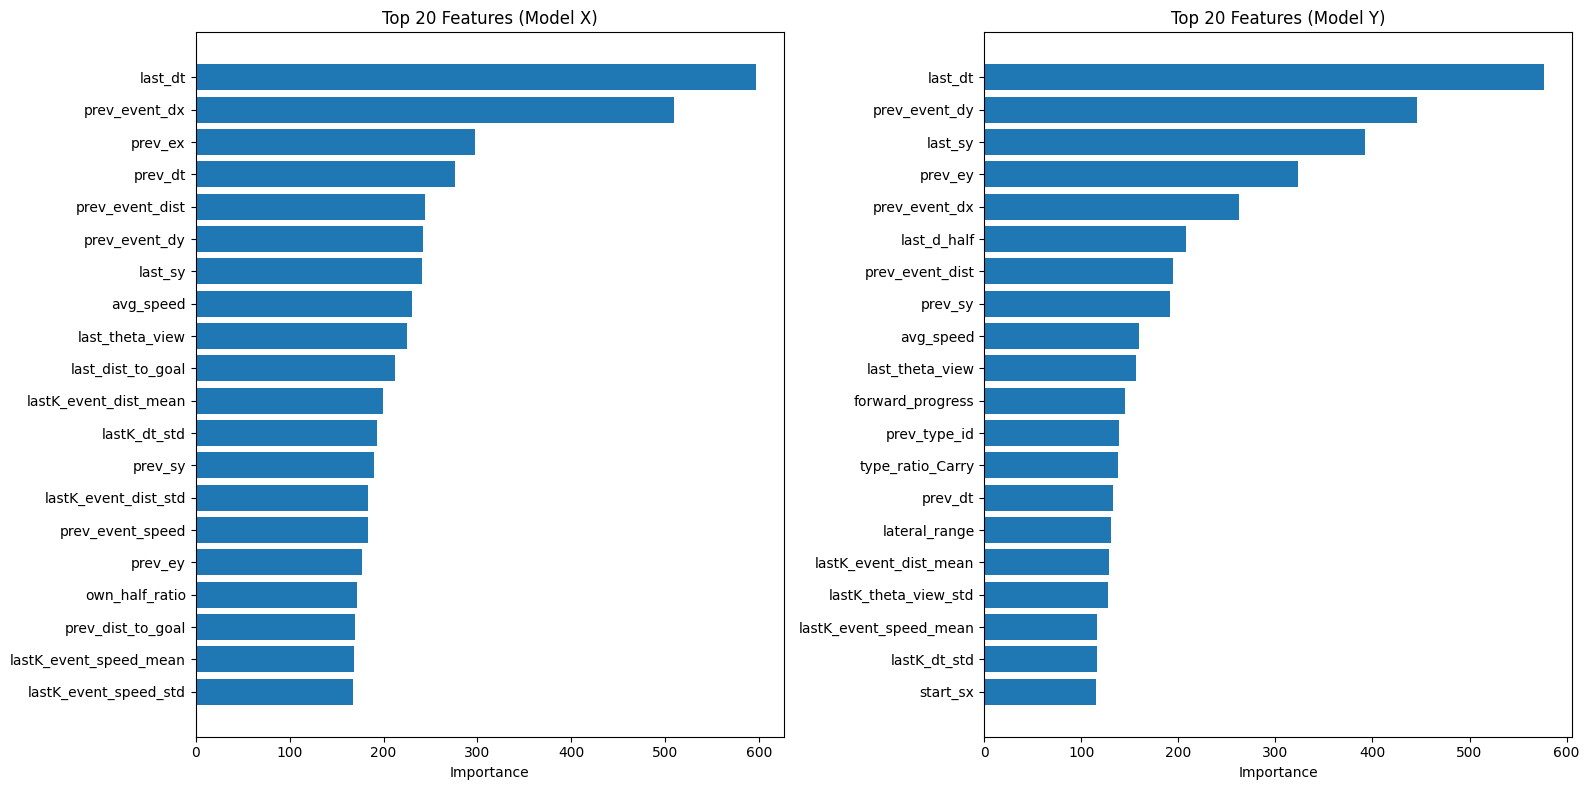

In [10]:
# Feature importance visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Model X importance
importance_x = pd.DataFrame({
    "feature": X.columns,
    "importance": model_x.feature_importances_
}).sort_values("importance", ascending=False).head(20)

axes[0].barh(importance_x["feature"], importance_x["importance"])
axes[0].invert_yaxis()
axes[0].set_title("Top 20 Features (Model X)")
axes[0].set_xlabel("Importance")

# Model Y importance
importance_y = pd.DataFrame({
    "feature": X.columns,
    "importance": model_y.feature_importances_
}).sort_values("importance", ascending=False).head(20)

axes[1].barh(importance_y["feature"], importance_y["importance"])
axes[1].invert_yaxis()
axes[1].set_title("Top 20 Features (Model Y)")
axes[1].set_xlabel("Importance")

plt.tight_layout()
plt.show()

## 7. 평가 데이터셋 추론

In [11]:
TEST_META_PATH = "../data/test.csv"
SUBMISSION_PATH = "../data/sample_submission.csv"
DATA_ROOT = "../data"

test_meta = pd.read_csv(TEST_META_PATH)
submission = pd.read_csv(SUBMISSION_PATH)

def build_test_episode_row(g):
    """
    Build tabular row for a test episode.
    Same logic as training, but handles unseen categories.
    """
    g = g.sort_values(["time_seconds", "action_id"]).reset_index(drop=True)
    
    # fill categories
    g["type_name"] = g["type_name"].fillna("__NA_TYPE__")
    g["result_name"] = g["result_name"].fillna("__NA_RES__")
    
    # handle unseen labels
    g.loc[~g["type_name"].isin(le_type.classes_), "type_name"] = "__NA_TYPE__"
    g.loc[~g["result_name"].isin(le_res.classes_), "result_name"] = "__NA_RES__"
    
    g["type_id"] = le_type.transform(g["type_name"])
    g["res_id"]  = le_res.transform(g["result_name"])
    
    # compute features
    feats = compute_event_features(g)
    
    # convert to tabular
    row = episode_to_tabular(g, feats, agg_k=AGG_LAST_K)
    
    return row

# Build test features
test_rows = []
test_keys = []

for _, row in tqdm(test_meta.iterrows(), total=len(test_meta)):
    game_episode = row["game_episode"]
    
    rel_path = str(row["path"])
    rel_path = rel_path[2:] if rel_path.startswith("./") else rel_path
    full_path = os.path.join(DATA_ROOT, rel_path)
    
    g = pd.read_csv(full_path)
    
    test_row = build_test_episode_row(g)
    test_rows.append(test_row)
    test_keys.append(game_episode)

X_test = pd.DataFrame(test_rows)

# Ensure columns match training
missing_cols = set(X.columns) - set(X_test.columns)
for col in missing_cols:
    X_test[col] = 0.0
X_test = X_test[X.columns]  # reorder to match training

print("X_test shape:", X_test.shape)

100%|██████████| 2414/2414 [00:07<00:00, 320.48it/s]

X_test shape: (2414, 96)


In [12]:
# Predict
pred_x_test = model_x.predict(X_test)
pred_y_test = model_y.predict(X_test)

# Map predictions to submission
pred_map = {k: (px, py) for k, px, py in zip(test_keys, pred_x_test, pred_y_test)}

preds_x = []
preds_y = []
missing = []

for ge in submission["game_episode"].tolist():
    if ge not in pred_map:
        missing.append(ge)
        preds_x.append(0.0)
        preds_y.append(0.0)
        continue
    px, py = pred_map[ge]
    preds_x.append(float(px))
    preds_y.append(float(py))

if len(missing) > 0:
    print("warning: missing episodes:", len(missing))

submission["end_x"] = preds_x
submission["end_y"] = preds_y

print("inference done:", len(submission))

inference done: 2414


## 8. 제출 Submission 생성

In [13]:
base = "LGBM_1_submit"
ext = ".csv"

i = 0
while True:
    out_name = f"{base}_{i}{ext}"
    if not os.path.exists(out_name):
        break
    i += 1

submission[["game_episode", "end_x", "end_y"]].to_csv(out_name, index=False)
print("saved:", out_name)

saved: LGBM_1_submit_2.csv
